 ### ** Implementation of Graph Convolutional Networks in TensorFlow ** 
https://github.com/tkipf/gcn 

The dataset being used is the CiteSeer dataset , available here : https://linqs.soe.ucsc.edu/data . It contains 1504 machine learning documents with 2892 author references to 165 author entities. 


The dataset consists of two files - content and cites . 

** Content **

descriptions of the papers in the following format:

< paper_id > < word_attributes >+ < class_label >

Classes are Agents , AI , DB , IR , ML , HCI 


** Cites ** 

The citation graph of the corpus. Each line describes a link in the following format:

< ID of cited paper > < ID of citing paper >

In [9]:
import numpy as np 
import pandas as pd
from scipy.sparse import csr_matrix
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import time
%matplotlib inline

In [ ]:
# Looking at the cites file 

In [5]:
# load file
project_path = "/Users/vsokolov/Dropbox/proj/dl-graph/"
cites = pd.read_table(project_path + "data/citeseer/citeseer.cites")
cites = cites.rename(columns = {'100157':'cited','100157.1' : 'citing'})

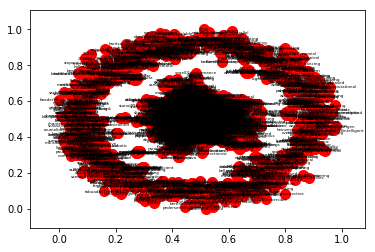

In [10]:
# quickly visualize the graph 
G= nx.Graph()
for i in range(0,len(cites)):
        G.add_edge(cites['cited'][i],cites['citing'][i])
nx.draw_networkx(G, size = 100 , font_size = 4, node_size = 100)

In [49]:
# looking at the content file 

In [8]:
content = pd.read_table(project_path + "data/citeseer/citeseer.content", low_memory=False)
content.head()
# the first column is the paper ID , the middle columns are all features , the last column is the classification 

,100157,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.3663,0.3664,0.3665,0.3666,0.3667,0.3668,0.3669,0.3670,0.3671,Agents
0,100598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,IR
1,105684,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Agents
2,11099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DB
3,114091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AI
4,11510,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AI


Our dataset can also follow a similar pattern, with each input and output transaction as a row .

The transaction amount and classification can be columns. 

In [121]:
# quickly view the data files in python . Need to unpickle and compress matrix . 
# for x,y,allx,ally,tx,ty

# change x to any other in read_pickle to view how each element looks 
x = csr_matrix(pd.read_pickle('ind.citeseer.x')).toarray()

#graph
y=pd.DataFrame.from_dict(pd.read_pickle('ind.citeseer.graph'),orient='index')

#test.index
z = []
for line in open('ind.citeseer.test.index','r').readlines():
    z.append(line.strip())


In [32]:
# Now , let us go through the different parts of the code 

In [3]:
# Initializations 
# inits.py - the author is defining the random initializations that will be used for the shape objects in tf. 


def uniform(shape, scale=0.05, name=None):
    """Uniform init."""
    initial = tf.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def glorot(shape, name=None):
    """Specifying the initialization method as used by Glorot & Bengio - 
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.207.2059&rep=rep1&type=pdf """
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random_uniform(shape, minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def zeros(shape, name=None):
    """All zeros."""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def ones(shape, name=None):
    """All ones."""
    initial = tf.ones(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

In [4]:
# the metrics being used to determine the accuracy and the softmax used in the final layer are being defined. 

In [14]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    print loss
    return tf.reduce_mean(loss)


def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)


In [18]:
# The data preprocessing part 
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """Loading the data from the files. 
    The pickle files are being loaded and appended to an empty list.   """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
"""The citeseer dataset has some issues. Being taken care of here. """
    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended
    """ Here , the author is vertically stacking the rows in the data and constructing a sparse matrix out of it. 
    This is being done for the entire x value superset ,  feature vectors of the training data, output. . 
    The graph data is being converted to a adjacency matrix in networkx. """
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    
    """sample_mask takes idx and l as inputs. They're being defined and being assigned to train , val , test. """
    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])
    """mask part of the outputs being assigned to labels[]"""
    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


IndentationError: unexpected indent (<ipython-input-18-89ff2a11383f>, line 33)

In [7]:
# layer definitions 
import tensorflow as tf

flags = tf.app.flags
FLAGS = flags.FLAGS

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}


def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]


def sparse_dropout(x, keep_prob, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1./keep_prob)


def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse_tensor_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res


class Layer(object):
    """Base layer class. Defines basic API for all layer objects.
    Implementation inspired by keras (http://keras.io).

    # Properties
        name: String, defines the variable scope of the layer.
        logging: Boolean, switches Tensorflow histogram logging on/off

    # Methods
        _call(inputs): Defines computation graph of layer
            (i.e. takes input, returns output)
        __call__(inputs): Wrapper for _call()
        _log_vars(): Log all variables
    """

    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            layer = self.__class__.__name__.lower()
            name = layer + '_' + str(get_layer_uid(layer))
        self.name = name
        self.vars = {}
        logging = kwargs.get('logging', False)
        self.logging = logging
        self.sparse_inputs = False

    def _call(self, inputs):
        return inputs

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            if self.logging and not self.sparse_inputs:
                tf.summary.histogram(self.name + '/inputs', inputs)
            outputs = self._call(inputs)
            if self.logging:
                tf.summary.histogram(self.name + '/outputs', outputs)
            return outputs

    def _log_vars(self):
        for var in self.vars:
            tf.summary.histogram(self.name + '/vars/' + var, self.vars[var])


class Dense(Layer):
    """Dense layer."""
    def __init__(self, input_dim, output_dim, placeholders, dropout=0., sparse_inputs=False,
                 act=tf.nn.relu, bias=False, featureless=False, **kwargs):
        super(Dense, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = glorot([input_dim, output_dim],
                                          name='weights')
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # transform
        output = dot(x, self.vars['weights'], sparse=self.sparse_inputs)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


class GraphConvolution(Layer):
    """Graph convolution layer
     Dropout is being used as defined in utils. 
     convolution is done... sparse weights are being matmul and being added to output. 
    """
    def __init__(self, input_dim, output_dim, placeholders, dropout=0.,
                 sparse_inputs=False, act=tf.nn.relu, bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        if dropout:
            self.dropout = placeholders['dropout']
        else:
            self.dropout = 0.

        self.act = act
        self.support = placeholders['support']
        self.sparse_inputs = sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # helper variable for sparse dropout
        self.num_features_nonzero = placeholders['num_features_nonzero']

        with tf.variable_scope(self.name + '_vars'):
            for i in range(len(self.support)):
                self.vars['weights_' + str(i)] = glorot([input_dim, output_dim],
                                                        name='weights_' + str(i))
            if self.bias:
                self.vars['bias'] = zeros([output_dim], name='bias')

        if self.logging:
            self._log_vars()

    def _call(self, inputs):
        x = inputs

        # dropout
        if self.sparse_inputs:
            x = sparse_dropout(x, 1-self.dropout, self.num_features_nonzero)
        else:
            x = tf.nn.dropout(x, 1-self.dropout)

        # convolve
        supports = list()
        for i in range(len(self.support)):
            if not self.featureless:
                pre_sup = dot(x, self.vars['weights_' + str(i)],
                              sparse=self.sparse_inputs)
            else:
                pre_sup = self.vars['weights_' + str(i)]
            support = dot(self.support[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.vars['bias']

        return self.act(output)


In [13]:
# models 

"""
Two models are being used here : MLP and GCN(as classes) with Loss , accuracy , build and predict functions defined in them. 
"""
flags = tf.app.flags
FLAGS = flags.FLAGS


class Model(object):
    def __init__(self, **kwargs):
        allowed_kwargs = {'name', 'logging'}
        for kwarg in kwargs.keys():
            assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        name = kwargs.get('name')
        if not name:
            name = self.__class__.__name__.lower()
        self.name = name

        logging = kwargs.get('logging', False)
        self.logging = logging

        self.vars = {}
        self.placeholders = {}

        self.layers = []
        self.activations = []

        self.inputs = None
        self.outputs = None

        self.loss = 0
        self.accuracy = 0
        self.optimizer = None
        self.opt_op = None

    def _build(self):
        raise NotImplementedError

    def build(self):
        """ Wrapper for _build() """
        with tf.variable_scope(self.name):
            self._build()

        # Build sequential layer model
        self.activations.append(self.inputs)
        for layer in self.layers:
            hidden = layer(self.activations[-1])
            self.activations.append(hidden)
        self.outputs = self.activations[-1]

        # Store model variables for easy access
        variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
        self.vars = {var.name: var for var in variables}

        # Build metrics
        self._loss()
        self._accuracy()

        self.opt_op = self.optimizer.minimize(self.loss)

    def predict(self):
        pass

    def _loss(self):
        raise NotImplementedError

    def _accuracy(self):
        raise NotImplementedError

    def save(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = saver.save(sess, "tmp/%s.ckpt" % self.name)
        print("Model saved in file: %s" % save_path)

    def load(self, sess=None):
        if not sess:
            raise AttributeError("TensorFlow session not provided.")
        saver = tf.train.Saver(self.vars)
        save_path = "tmp/%s.ckpt" % self.name
        saver.restore(sess, save_path)
        print("Model restored from file: %s" % save_path)


class MLP(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):
        self.layers.append(Dense(input_dim=self.input_dim,
                                 output_dim=FLAGS.hidden1,
                                 placeholders=self.placeholders,
                                 act=tf.nn.relu,
                                 dropout=True,
                                 sparse_inputs=True,
                                 logging=self.logging))

        self.layers.append(Dense(input_dim=FLAGS.hidden1,
                                 output_dim=self.output_dim,
                                 placeholders=self.placeholders,
                                 act=lambda x: x,
                                 dropout=True,
                                 logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
                                                  self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)


In [10]:
# Training 

# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))


Epoch: 0001 train_loss= 1.95399 train_acc= 0.07143 val_loss= 1.95070 val_acc= 0.20600 time= 0.15391
Epoch: 0002 train_loss= 1.94801 train_acc= 0.29286 val_loss= 1.94716 val_acc= 0.37000 time= 0.12132
Epoch: 0003 train_loss= 1.94218 train_acc= 0.48571 val_loss= 1.94333 val_acc= 0.47000 time= 0.10277
Epoch: 0004 train_loss= 1.93654 train_acc= 0.56429 val_loss= 1.93922 val_acc= 0.50400 time= 0.10929
Epoch: 0005 train_loss= 1.92665 train_acc= 0.66429 val_loss= 1.93517 val_acc= 0.50400 time= 0.08623
Epoch: 0006 train_loss= 1.92017 train_acc= 0.70000 val_loss= 1.93110 val_acc= 0.51400 time= 0.08523
Epoch: 0007 train_loss= 1.91050 train_acc= 0.71429 val_loss= 1.92704 val_acc= 0.52000 time= 0.08433
Epoch: 0008 train_loss= 1.89941 train_acc= 0.71429 val_loss= 1.92310 val_acc= 0.51600 time= 0.08774
Epoch: 0009 train_loss= 1.89015 train_acc= 0.75714 val_loss= 1.91920 val_acc= 0.52000 time= 0.09375
Epoch: 0010 train_loss= 1.88369 train_acc= 0.67143 val_loss= 1.91527 val_acc= 0.52000 time= 0.09826


Epoch: 0084 train_loss= 0.97093 train_acc= 0.93571 val_loss= 1.37043 val_acc= 0.77600 time= 0.08322
Epoch: 0085 train_loss= 0.94742 train_acc= 0.96429 val_loss= 1.36384 val_acc= 0.77600 time= 0.08222
Epoch: 0086 train_loss= 0.94996 train_acc= 0.93571 val_loss= 1.35739 val_acc= 0.77800 time= 0.08272
Epoch: 0087 train_loss= 0.97249 train_acc= 0.92857 val_loss= 1.35100 val_acc= 0.78000 time= 0.08424
Epoch: 0088 train_loss= 0.94913 train_acc= 0.93571 val_loss= 1.34459 val_acc= 0.78000 time= 0.08322
Epoch: 0089 train_loss= 0.97455 train_acc= 0.91429 val_loss= 1.33826 val_acc= 0.78000 time= 0.08222
Epoch: 0090 train_loss= 0.97957 train_acc= 0.91429 val_loss= 1.33204 val_acc= 0.78000 time= 0.08474
Epoch: 0091 train_loss= 0.92480 train_acc= 0.95000 val_loss= 1.32596 val_acc= 0.78000 time= 0.08222
Epoch: 0092 train_loss= 0.95817 train_acc= 0.92143 val_loss= 1.32011 val_acc= 0.78000 time= 0.07971
Epoch: 0093 train_loss= 0.89500 train_acc= 0.95000 val_loss= 1.31456 val_acc= 0.77800 time= 0.08322


Epoch: 0168 train_loss= 0.69909 train_acc= 0.95000 val_loss= 1.10069 val_acc= 0.78000 time= 0.08623
Epoch: 0169 train_loss= 0.65012 train_acc= 0.96429 val_loss= 1.10006 val_acc= 0.78200 time= 0.08172
Epoch: 0170 train_loss= 0.66773 train_acc= 0.95000 val_loss= 1.09972 val_acc= 0.78200 time= 0.08372
Epoch: 0171 train_loss= 0.72109 train_acc= 0.92857 val_loss= 1.09840 val_acc= 0.78200 time= 0.08472
Epoch: 0172 train_loss= 0.67563 train_acc= 0.95714 val_loss= 1.09644 val_acc= 0.78200 time= 0.08323
Epoch: 0173 train_loss= 0.64704 train_acc= 0.97143 val_loss= 1.09398 val_acc= 0.78200 time= 0.08121
Epoch: 0174 train_loss= 0.58342 train_acc= 0.98571 val_loss= 1.09138 val_acc= 0.77800 time= 0.08623
Epoch: 0175 train_loss= 0.67515 train_acc= 0.94286 val_loss= 1.08887 val_acc= 0.77400 time= 0.08322
Epoch: 0176 train_loss= 0.68394 train_acc= 0.93571 val_loss= 1.08582 val_acc= 0.77800 time= 0.08172
Epoch: 0177 train_loss= 0.70085 train_acc= 0.94286 val_loss= 1.08304 val_acc= 0.77800 time= 0.08473


In [17]:
# Next step : Decoupled Neural Interfaces using Synthetic Gradients for PyTorch
# https://github.com/koz4k/dni-pytorch 
# Have not fully understood this part of the code . 

In [ ]:
    from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import dni

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--dni', action='store_true', default=False,
                    help='enable DNI')
parser.add_argument('--context', action='store_true', default=False,
                    help='enable context (label conditioning) in DNI')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


def one_hot(indexes, n_classes):
    result = torch.FloatTensor(indexes.size() + (n_classes,))
    if args.cuda:
        result = result.cuda()
    result.zero_()
    indexes_rank = len(indexes.size())
    result.scatter_(
        dim=indexes_rank,
        index=indexes.data.unsqueeze(dim=indexes_rank),
        value=1
    )
    return Variable(result)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        if args.dni:
            self.backward_interface = dni.BackwardInterface(ConvSynthesizer())
        self.fc1 = nn.Linear(320, 50)
        self.fc1_bn = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 10)
        self.fc2_bn = nn.BatchNorm1d(10)

    def forward(self, x, y=None):
        x = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(x)), 2))
        x = F.max_pool2d(self.conv2_drop(self.conv2_bn(self.conv2(x))), 2)
        if args.dni and self.training:
            if args.context:
                context = one_hot(y, 10)
            else:
                context = None
            with dni.synthesizer_context(context):
                x = self.backward_interface(x)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2_bn(self.fc2(x))
        return F.log_softmax(x)


class ConvSynthesizer(nn.Module):
    def __init__(self):
        super(ConvSynthesizer, self).__init__()
        self.input_trigger = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        self.input_context = nn.Linear(10, 20)
        self.hidden = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        self.output = nn.Conv2d(20, 20, kernel_size=5, padding=2)
        # zero-initialize the last layer, as in the paper
        nn.init.constant(self.output.weight, 0)

    def forward(self, trigger, context):
        x = self.input_trigger(trigger)
        if context is not None:
            x += (
                self.input_context(context).unsqueeze(2)
                                           .unsqueeze(3)
                                           .expand_as(x)
            )
        x = self.hidden(F.relu(x))
        return self.output(F.relu(x))


model = Net()
if args.cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args.lr)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test()